In [1]:
from neurodiffeq import diff
from neurodiffeq.pde import DirichletBVP2D, ExampleGenerator2D, Monitor2D, solve2D, make_animation
from neurodiffeq.networks import FCNN

import numpy as np
import torch
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d  import Axes3D

# a helper function to plot surface
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.set_proj_type('ortho')
    plt.show()

In [2]:
# http://www.bcamath.org/projects/NUMERIWAVES/Burgers_Equation_M_Landajuela.pdf
import numpy as np

L, T = 6, 10
Nx, Nt =64, 512

x = np.linspace(-1.0/Nx, L, Nx+2)    # mesh points in space
dx = x[1] - x[0]
t = np.linspace(0, T, Nt+1)    # mesh points in time
dt = t[1] - t[0]
F = dt/dx
U = np.zeros((Nt+1, Nx+2))
U[0, :] = np.exp(-(x-1)**2)

for n in range(1, Nt+1):
    # Compute u at inner mesh points
    for i in range(1, Nx):
        U[n][i] = U[n-1][i] - F*(0.5*U[n-1][i]**2 - 0.5*U[n-1][i-1]**2)

U = U[:, 1:]

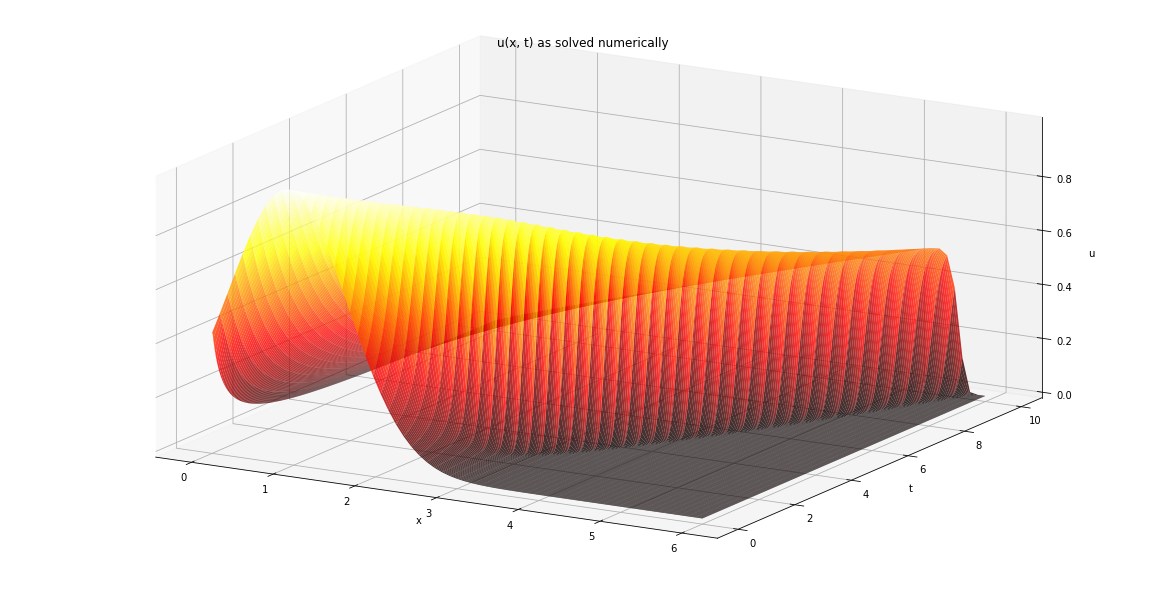

In [3]:
xs, ts = np.linspace(0, L, Nx+1), np.linspace(0, T, Nt+1)
xx, tt = np.meshgrid(xs, ts)
sol_num = U
plt_surf(xx, tt, sol_num, y_label='t', title='u(x, t) as solved numerically')

In [4]:
class IVP:
    
    def __init__(self, t_min, t_min_val):
        self.t_min, self.t_min_val = t_min, t_min_val
    
    def enforce(self, u, x, t):
        Axt = self.t_min_val(x)
        return Axt + (1-torch.exp(-t+self.t_min))*u

<IPython.core.display.Javascript object>


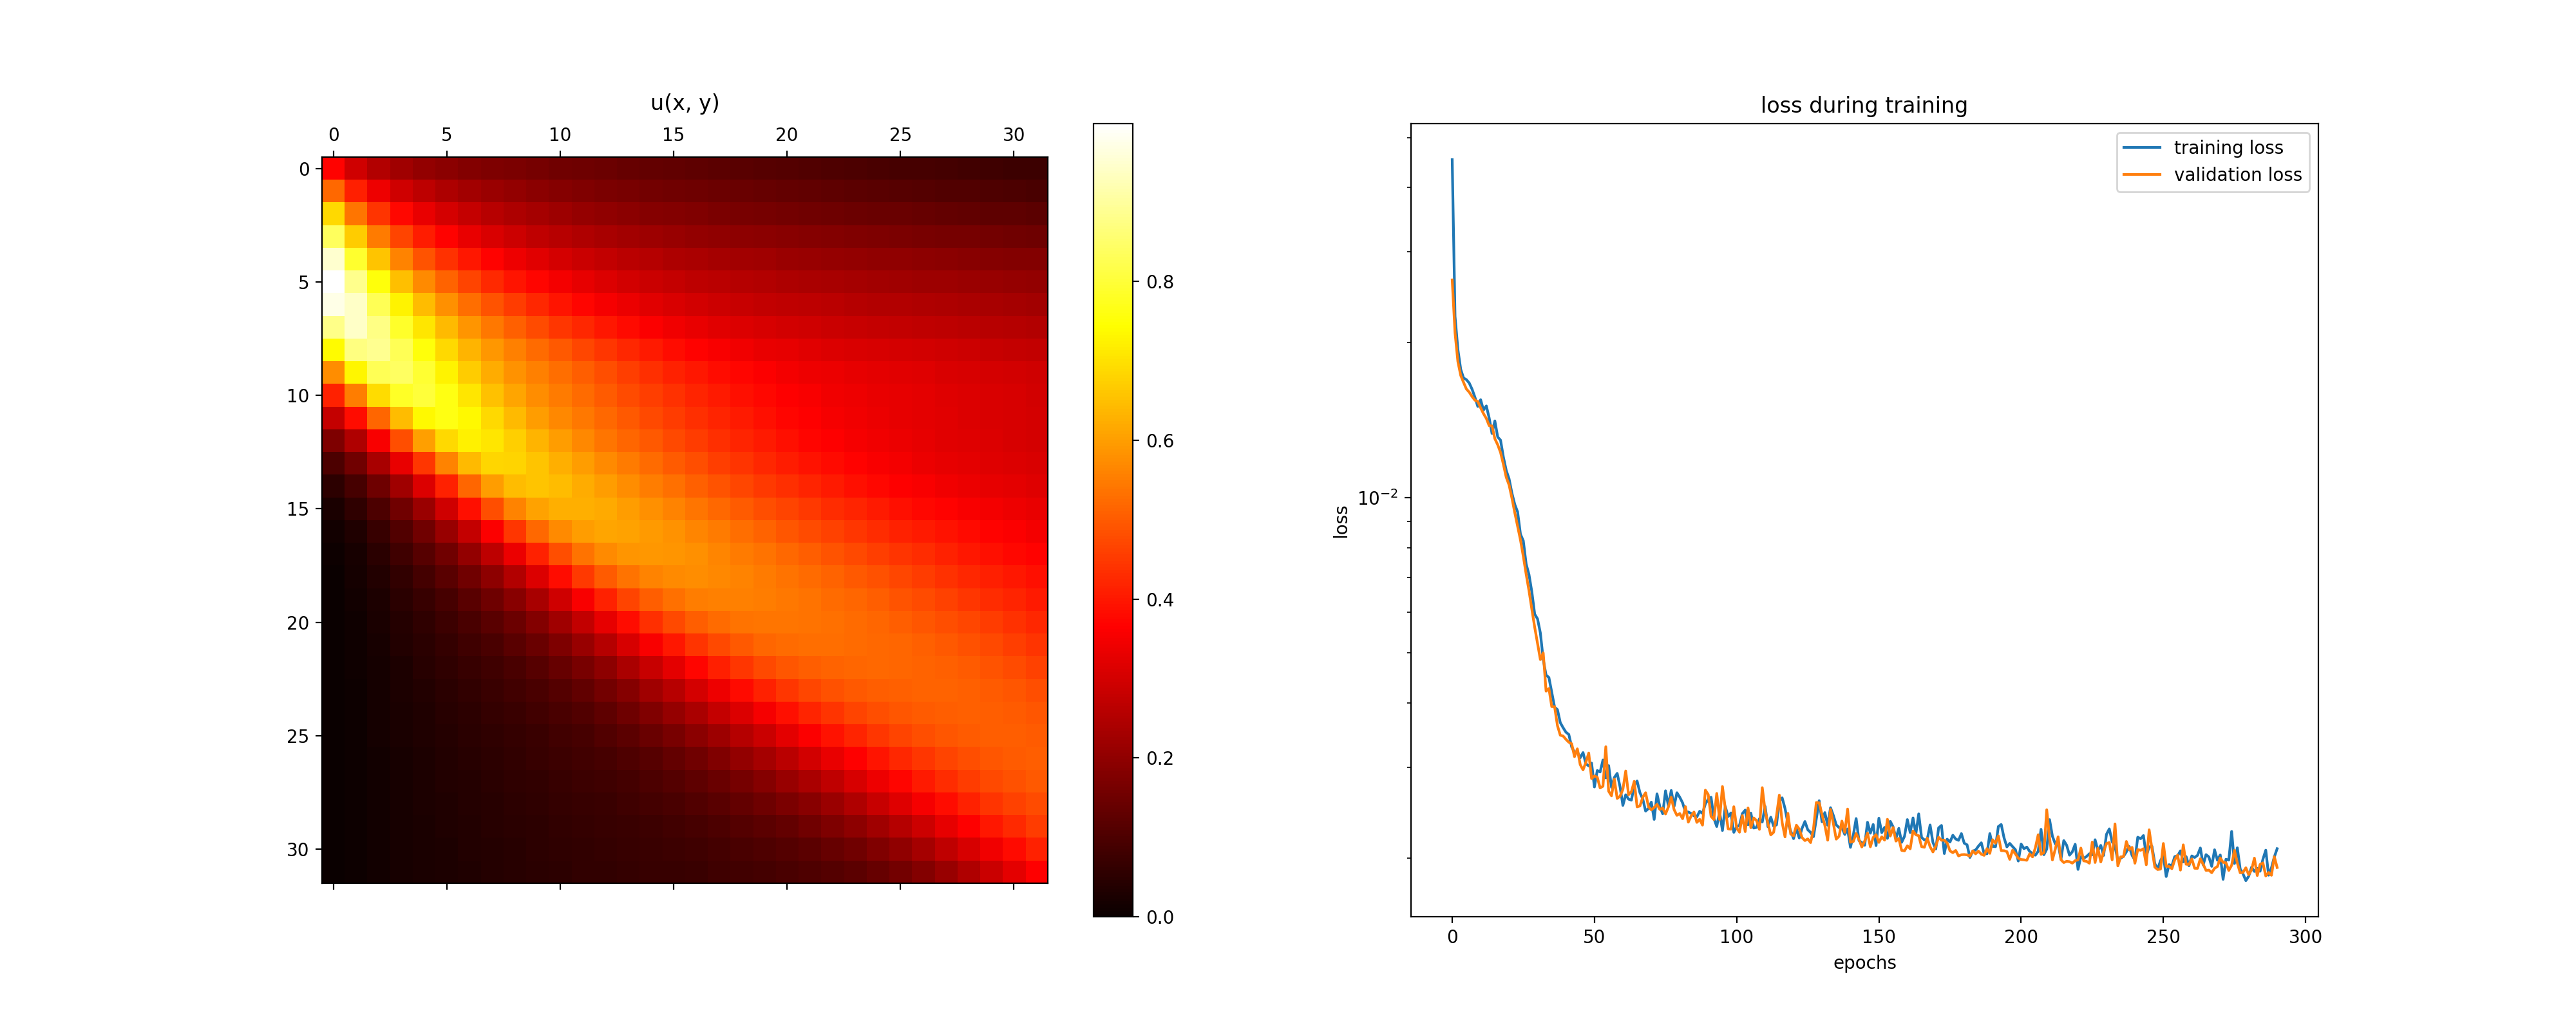

In [7]:
%matplotlib notebook
invisid_burgers = lambda u, x, t: diff(u, t) + u * diff(u, x)

IC = IVP(
    t_min=0, t_min_val=lambda x: torch.exp(-(x-1)**2)
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=2)

solution_neural_net, _ = solve2D(
    pde=invisid_burgers, condition=IC, xy_min=[0, 0], xy_max=[L, T],
    net=net, max_epochs=300, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [L, T], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[L, T])
)

<IPython.core.display.Javascript object>


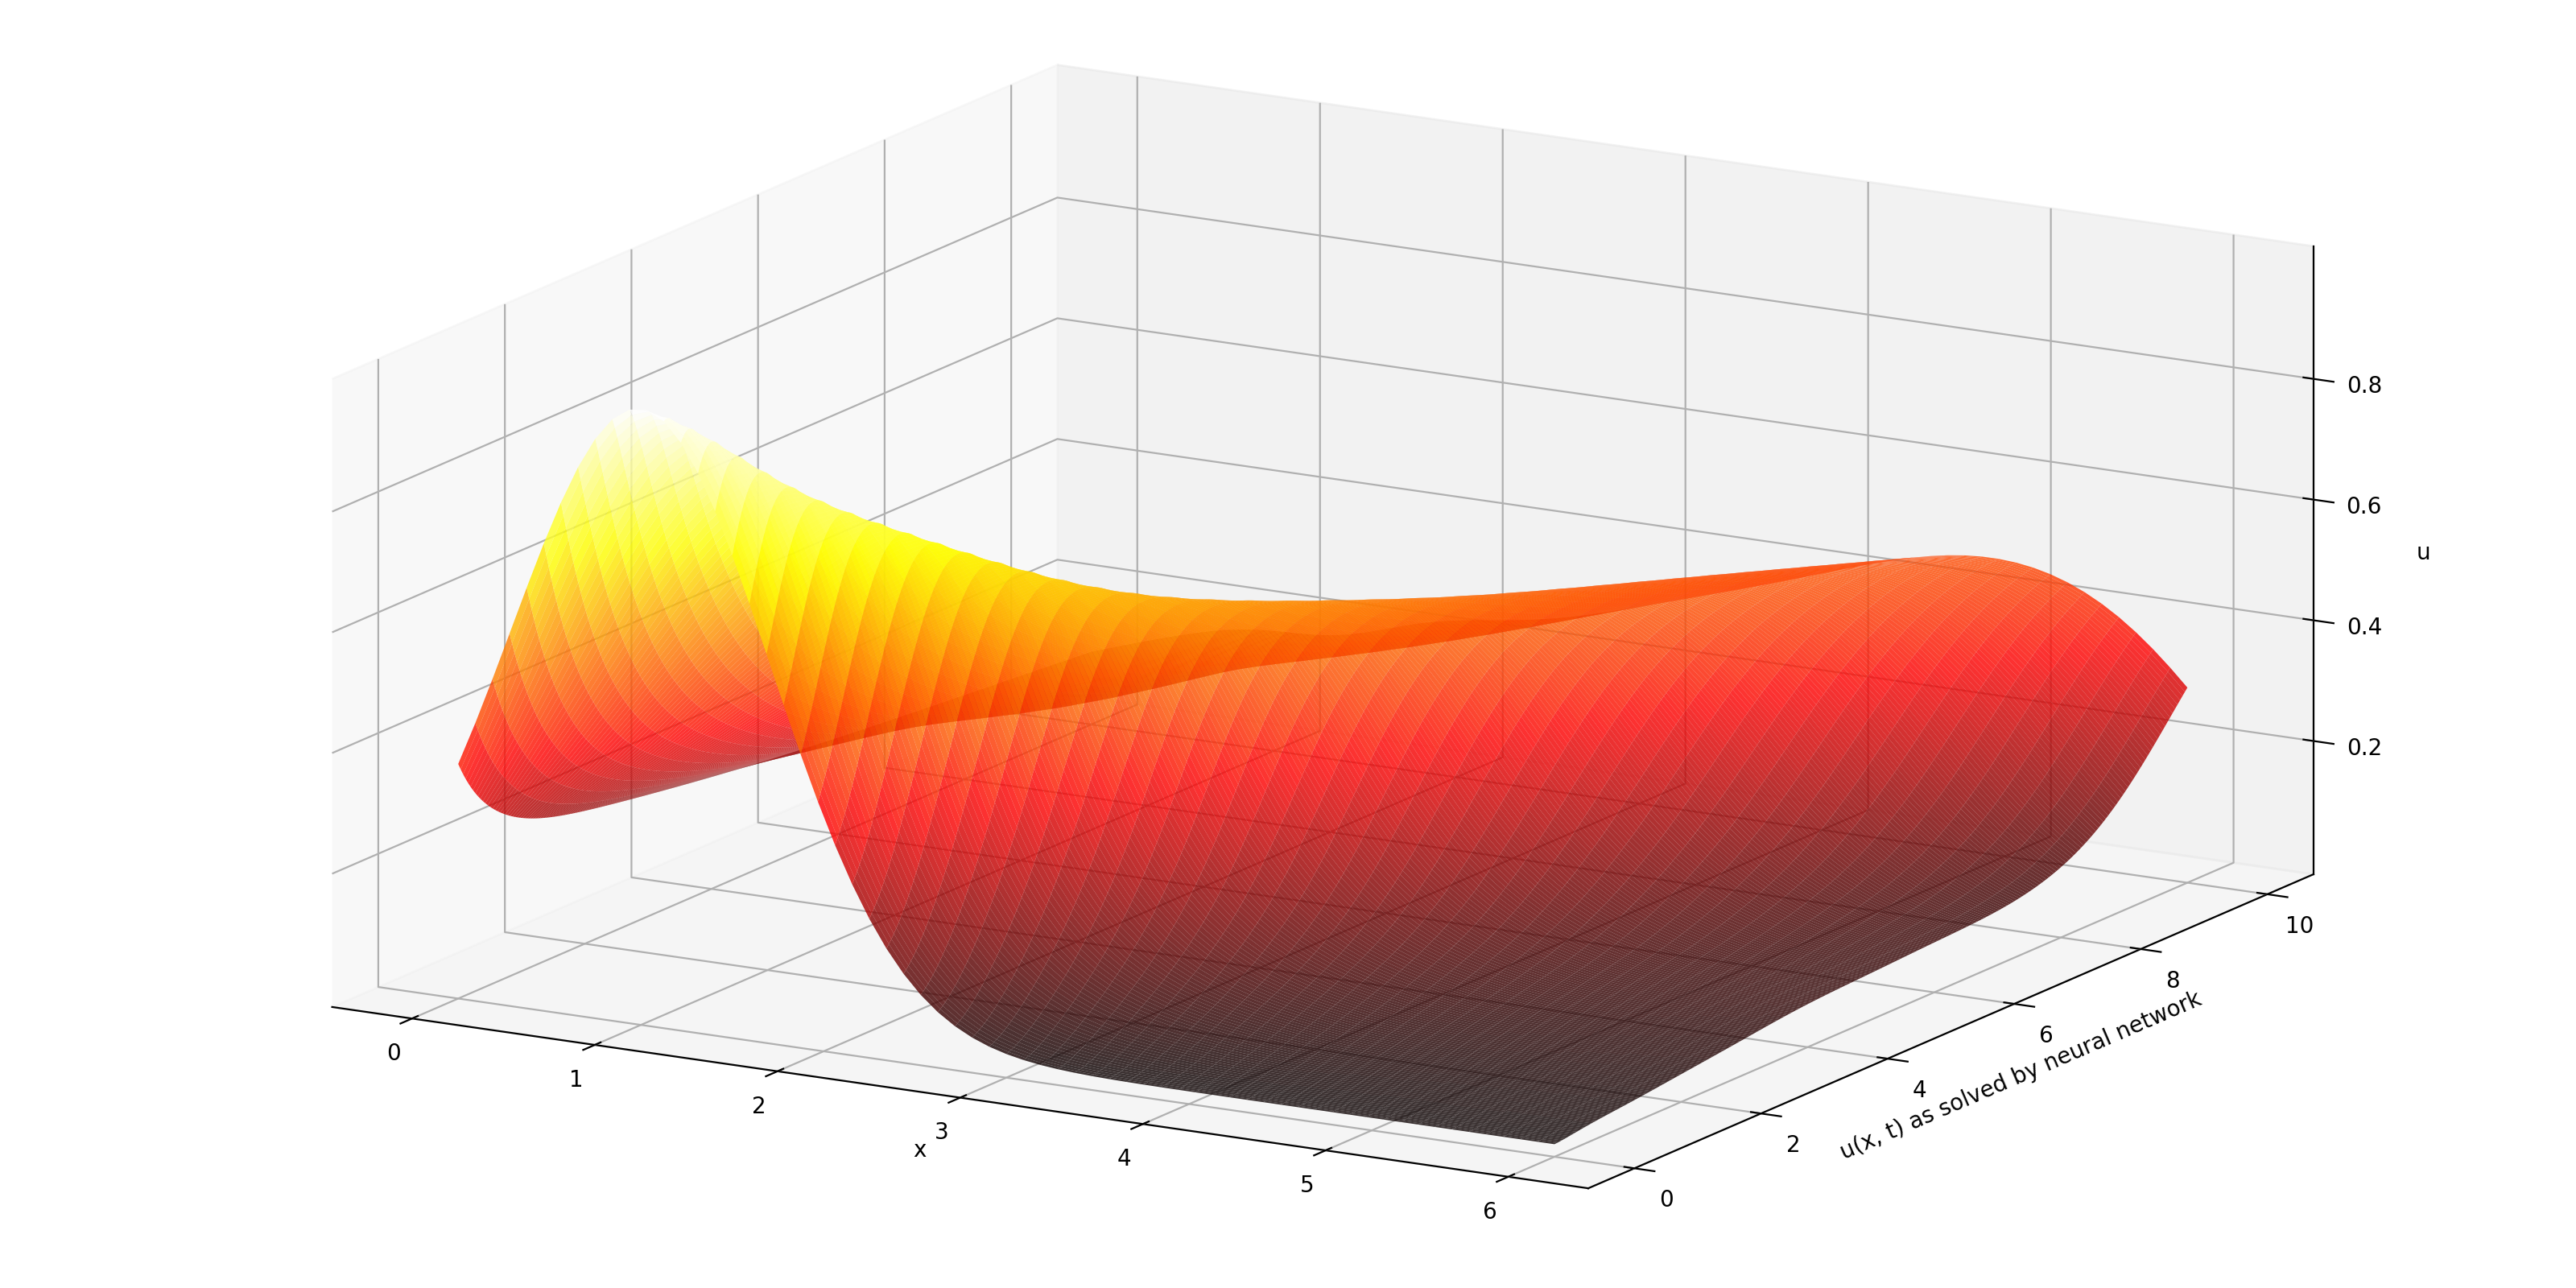

In [8]:
xs, ts = np.linspace(0, L, Nx+1), np.linspace(0, T, Nt+1)
xx, tt = np.meshgrid(xs, ts)
sol_net = solution_neural_net(xx, tt, as_type='np')
plt_surf(xx, tt, sol_net, y_label='u(x, t) as solved by neural network')

<IPython.core.display.Javascript object>


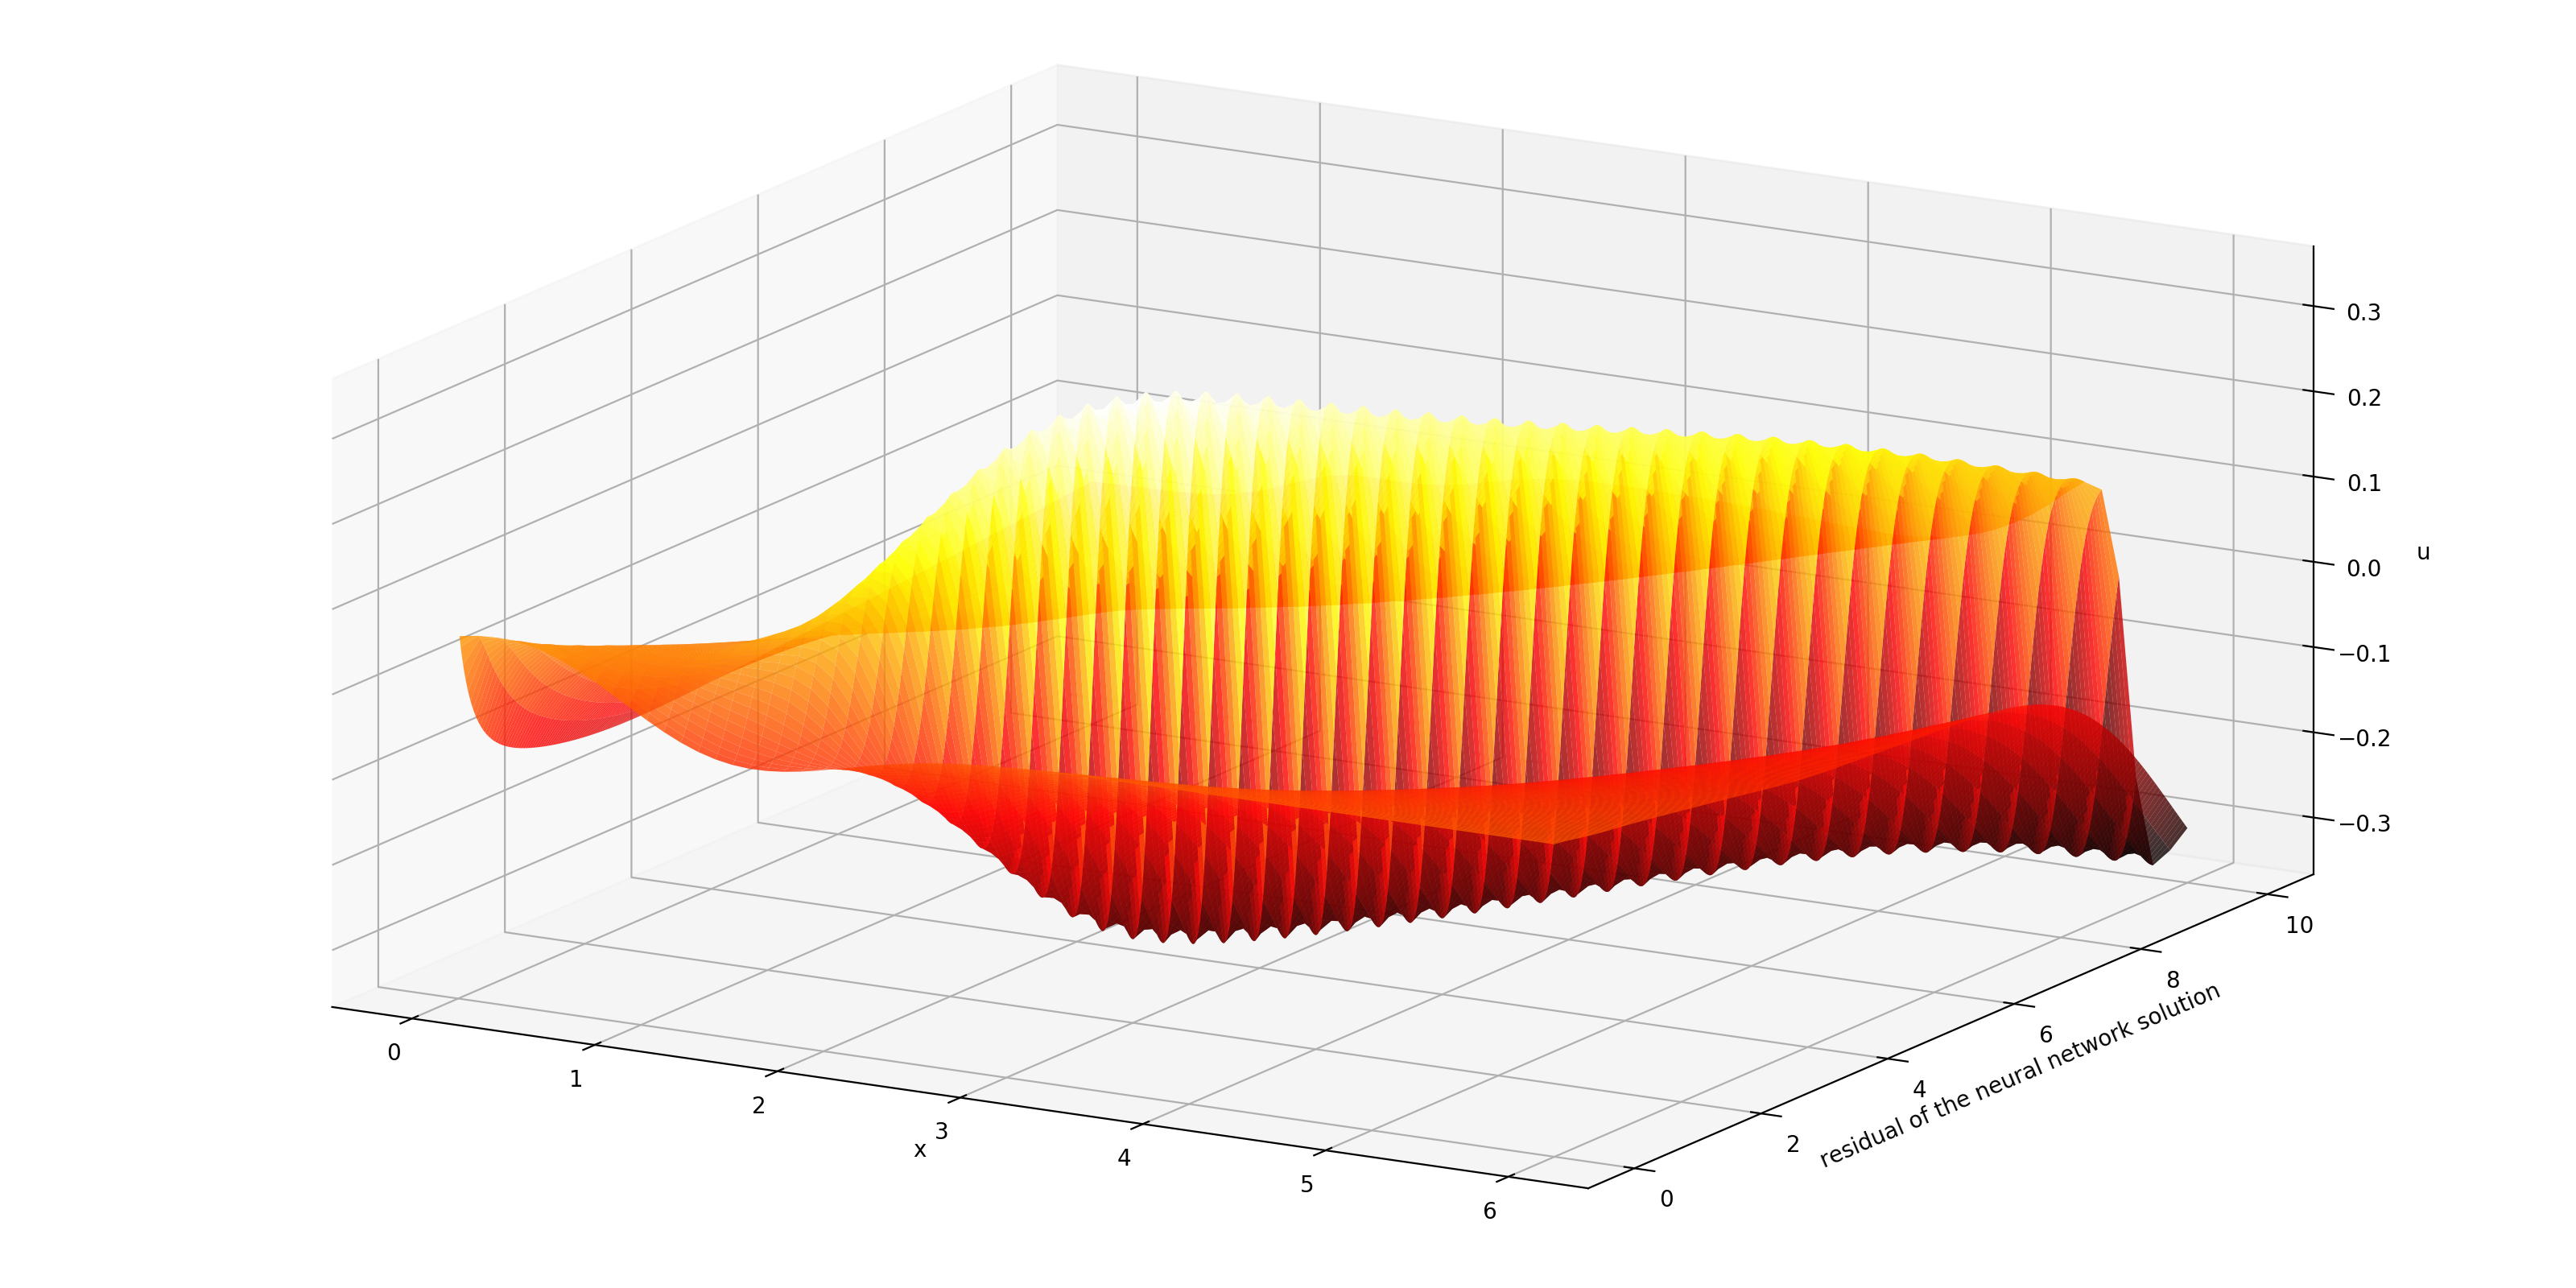

In [9]:
plt_surf(xx, tt, sol_num-sol_net, y_label='residual of the neural network solution')